# Exploration of the iberEval dataset

This notebook contains code used to analyse the relationships between categories using TF-IDF and Word2vec embeddings as well as different clustering methods. For this notebook, analysis was conducted on the data from the iberEval dataset, which contains only 5 categories, which are not equally represented. For an analysis of 19 more equally distributed categories, see **generalExploration.ipynb**. Most figures in the report are from that notebook and not from this one. Nevertheless, the two notebooks use the same methods and demonstrate how much the information gained differs when conducting similar experiments on such different datasets.

In [9]:
# import used python libraries
import pandas as pd
import numpy as np
import json
import nltk
import string
import re
import sys
sys.path.append("../")
from scripts.start import iberEval, sexists
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, v_measure_score, completeness_score, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter
import gensim.downloader as api
from scipy.cluster.hierarchy import dendrogram, complete
from scipy.cluster import hierarchy

# 1. Reading the iberEval dataset

In [10]:
# load the dataset
tweets, categories = iberEval()
dfCat = pd.DataFrame(categories, columns=["category"]).astype('category')
catCodes = dfCat['category'].cat.codes

# assign numbers to categories
catNumbers = [0 if c == "derailing" else
              1 if c == 'discredit' else 
              2 if c == 'dominance' else 
              3 if c == 'sexual_harassment' 
              else 4 for c in categories]

Counter(categories).most_common()    # There are 5 unique categories unequally represented in the dataset:

[('discredit', 943),
 ('sexual_harassment', 410),
 ('stereotype', 137),
 ('dominance', 49),
 ('derailing', 29)]

# 2. Exploration with the TF-IDF embeddings

## 2.1. Generating TF-IDF embeddings

In [11]:
# tokenizer to be used by the vectorizer
def tokenize_and_lemmatize(text):
    text = re.sub("[@]\w+", "", text) # remove tags
    # remove punctuation
    table = text.maketrans({key: None for key in string.punctuation})
    text = text.translate(table)
    text = re.sub("(http)\w+", "", text) # remove links
    tokens = nltk.word_tokenize(text)
    # lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens


# stopwords to be used by the vectorizer
# lemmatizer = WordNetLemmatizer()
englishwords = stopwords.words('english')
englishwords.extend(["u","rt","im","em","q","na","wan","’","“","”","…"])
englishwords.extend(tokenize_and_lemmatize(" ".join(englishwords)))


# The vectorizer using the tokenizer and prepared stopwords
tfidf_vec = TfidfVectorizer(max_df=0.95, 
                        max_features=10000,
                        min_df=5, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,3))

In [12]:
# get tf-idf representation of tweets with the vectorizer

tfidf_mat = tfidf_vec.fit_transform(tweets)
tfidf_mat.shape # 1568 tweets are represented with 571 TF-IDF values.

(1568, 558)

## 2.2. Clustering TF-IDF embeddings

In [13]:
# Mini-Batch K-Means speeds up the clustering process but may return slightly different results than K-Means
clusters = MiniBatchKMeans(n_clusters=5, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_mat)

# K-Means Turns out to be the same as minibatch
km = KMeans(n_clusters=5, random_state=20).fit(tfidf_mat)
clusters2 = km.predict(tfidf_mat)

# both clustering algorithms return clusters with low homogeneity
print("Mini-Batch K-Means Homogeneity:", homogeneity_score(clusters , catNumbers))
print("           K-Means Homogeneity:", homogeneity_score(clusters2, catNumbers))

Mini-Batch K-Means Homogeneity: 0.02882259597360959
           K-Means Homogeneity: 0.03154504559895453


In [14]:
# Evaluating which categories make most sense according to the V-Score based on cluster predictions
v_measures = []
for i in range(5):
    arCopy = np.array(catCodes.copy())
    arCopy[np.where(catCodes != i)] = -1
    v_measures.append(v_measure_score(arCopy, clusters))
    
print("Decreasing ordering of the categories according to the V-Score based on cluster predictions:\n")
print(" "*18+"| V measure |  Completeness | Homogeneity |")
for i in np.argsort(v_measures)[::-1]:
    arCopy = np.array(catCodes.copy())
    arCopy[np.where(catCodes != i)] = -1
    print("-"*60+"|\n"+"{:<17}".format(np.unique(categories)[i]) + " |    "+
          format(   v_measure_score(arCopy, clusters), ".4f")   + " |        "+ 
          format(completeness_score(arCopy, clusters), ".4f")   + " |      "+
          format( homogeneity_score(arCopy, clusters), ".4f") + " |")

Decreasing ordering of the categories according to the V-Score based on cluster predictions:

                  | V measure |  Completeness | Homogeneity |
------------------------------------------------------------|
discredit         |    0.0288 |        0.0214 |      0.0439 |
------------------------------------------------------------|
stereotype        |    0.0139 |        0.0084 |      0.0393 |
------------------------------------------------------------|
sexual_harassment |    0.0125 |        0.0089 |      0.0213 |
------------------------------------------------------------|
derailing         |    0.0072 |        0.0038 |      0.0574 |
------------------------------------------------------------|
dominance         |    0.0045 |        0.0025 |      0.0248 |


## 2.3. Visualizing TF-IDF embeddings  of each tweet

In [15]:
def plot_tsne_pca(data, labels,defLabels=None):
    max_label = max(labels)
    
    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
    
    f, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    pts = ax[0].scatter(pca[:, 0], pca[:, 1], c=labels, cmap="jet")
    ax[0].set_title('PCA Cluster Plot')
    #print(*pts.legend_elements())
    pts2 = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap="jet")
    ax[1].set_title('TSNE Cluster Plot')
    if defLabels is None:
        ax[0].legend(*pts.legend_elements())
        ax[1].legend(*pts2.legend_elements())
    else:
        ax[0].legend(pts.legend_elements()[0], defLabels)
        ax[1].legend(pts2.legend_elements()[0], defLabels)

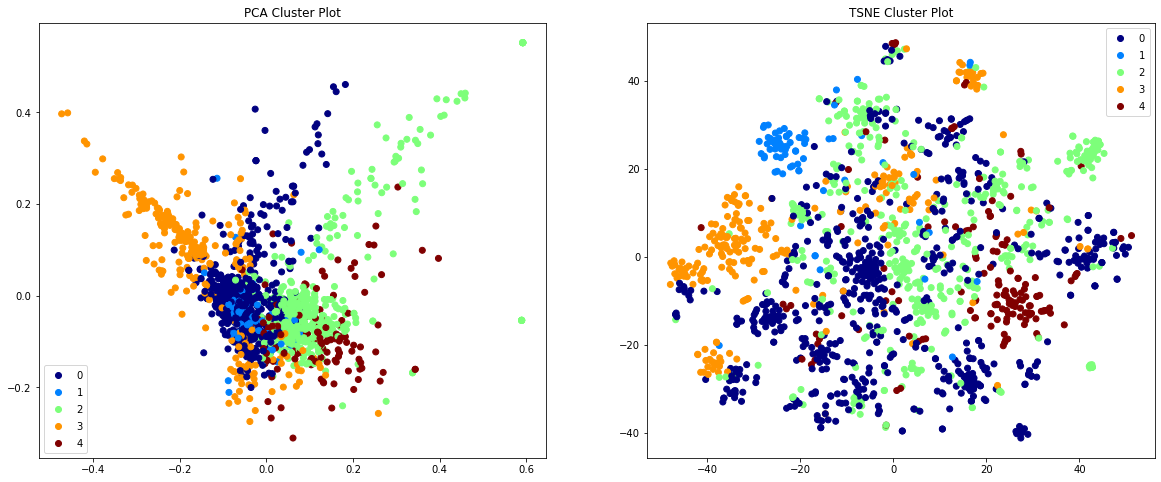

In [16]:
# using a similar approach as in the lab work.
plot_tsne_pca(tfidf_mat, clusters)

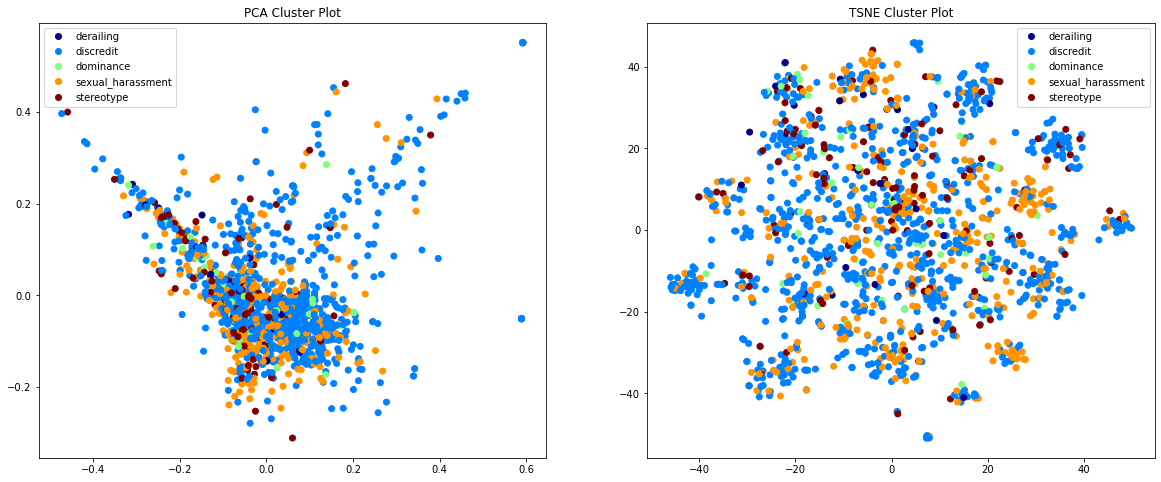

In [17]:
# this approach does not tell us a lot about the content of the tweets.
plot_tsne_pca(tfidf_mat, np.array(catNumbers), np.unique(categories))

## 2.4. Extracting most representative words using TF-IDF embeddings

In [18]:
# get the 10 most representative keywords for each cluster
def get_top_keywords(data, clusters, labels, n_terms, categoryNames=None):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        if categoryNames is None:
            print('\nCluster {}'.format(i))
        else:
            print('\nCluster {}'.format(categoryNames[i]))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]][::-1]))
            
get_top_keywords(tfidf_mat, clusters, tfidf_vec.get_feature_names(), n_terms=10)


Cluster 0
whore, slut, cunt, girl, woman, fuck, cock, hoe, rape, like

Cluster 1
bitches, dick, ass, shit, look, theres, cause, one, like, bitch

Cluster 2
bitch, stupid, like, pussy, stupid bitch, hoe, girl, get, got, fuck

Cluster 3
women, dick, men, suck, rape, bitch, like, suck dick, yesallmen, girl

Cluster 4
ass, bitch, ass bitch, bitch ass, fuck, hoe, dick, shit, pussy ass, pussy


In [19]:
# Get the actual keywords for each category
# derailing', 'discredit', 'dominance', 'sexual_harassment','stereotype'
get_top_keywords(tfidf_mat, np.array(catNumbers), tfidf_vec.get_feature_names(), 10, np.unique(categories))


Cluster derailing
women, rape, woman, men, women want, lol, every, man, dress, talking

Cluster discredit
bitch, women, stupid, whore, girl, like, hoe, ass, slut, pussy

Cluster dominance
like, men, bitch, women, yesallmen, cock, shut, whore, get, maledominance

Cluster sexual_harassment
dick, bitch, rape, cock, fuck, girl, ass, like, suck, pussy

Cluster stereotype
women, woman, dick, girl, like, one, bitch, bitches, yesallmen, men


Many words are shared between different categories, and its hard to tell some specifics, so it's hard to say that the categories are very sensible at first glance.
However, if we analyze the tweets that are labeled by different categories:

* derailing - usually tries to disregard women's issues by comparing with men, which is why those words are relevant. not too agressive language otherwise
* discredit - use of offensive vocabulary to insult people, usually women
* dominance - use of sexual language, usually to assert dominance of men over women
* sexual harrasment - use of sexual language

In [20]:
# alternative way:
# for each centroid, get ordered features by relevance
order_centroids =  km.cluster_centers_.argsort()[:, ::-1]
def getClusterWords(cluster, n=10):
    words = []
    for ind in order_centroids[cluster, :n]:
        words.append(tfidf_vec.get_feature_names()[ind])
    return ", ".join(words)

for i in range(5):
    print("Cluster {} words: {}".format(i, getClusterWords(i)))

Cluster 0 words: whore, slut, cunt, bitches, cock, girl, woman, like, fuck, rape
Cluster 1 words: women, men, rape, like, yesallmen, bitch, dick, want, many, man
Cluster 2 words: bitch, ass, pussy, girl, like, woman, get, fuck, ass bitch, shit
Cluster 3 words: dick, suck, bitch, suck dick, girl, ass, ya, like, dick bitch, got
Cluster 4 words: stupid, hoe, bitch, stupid bitch, fucking, cunt, stupid cunt, fuck, ass, like


We see some minor differences, but many words are the same, and we cant really infer a sensible topic/category to the generated clusters.

# 3. Using average Word2Vec embeddings to represent categories

## 3.1. Generate the average Word2Vec embedding for each tweet

In [21]:
# load the pretrained Word2vec model (download if not available)
word2vec = api.load('word2vec-google-news-300')
print("Model loaded.")

Model loaded.


In [22]:
# remove words (from previous tfidf result) which are not in word2vec vocabulary
words = tfidf_vec.get_feature_names()
notInVocab = [w not in word2vec for w in words]
englishwords.extend(list(np.array(words)[notInVocab]))
englishwords.extend(tokenize_and_lemmatize(" ".join(list(np.array(words)[notInVocab]))))

# This tokenizer will throw out the words which are not in word2vec vocabulary
tfidf_vec_2 = TfidfVectorizer(max_df=0.9, 
                        max_features=10000,
                        min_df=5, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize,
                        norm='l1',
                        use_idf=False,
                        ngram_range=(1,1))

In [23]:
# generate TFIDF representation of all tweets with updated stopwords
tfidf_mat_2 = tfidf_vec_2.fit_transform(tweets)
print( tfidf_mat_2.shape ) # 1568 tweets are represented with 480 TFIDF values.

(1568, 418)


In [24]:
# get average word2vec representation of each document
allwords = tfidf_vec_2.get_feature_names()
wordvectors = np.zeros((len(allwords),300))
for i in range(len(allwords)):
    wordvectors[i,:] = word2vec[allwords[i]]
    
docVectors = np.dot(tfidf_mat_2.todense(),wordvectors)
print(docVectors.shape) 

(1568, 300)


## 3.2 Cluster and visualize the categories using the Word2Vec embeddings

In [25]:
def plot_tsne_pca2(data, labels, defLabels=None):
    max_label = max(labels)
 
    pca = PCA(n_components=2).fit_transform(data)
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data))
    f, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    pts = ax[0].scatter(pca[:, 0], pca[:, 1], c=labels, cmap="jet")
    ax[0].set_title('PCA Cluster Plot')
    pts2 = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap="jet")
    ax[1].set_title('TSNE Cluster Plot')
    if defLabels is None:
        ax[0].legend(*pts.legend_elements())
        ax[1].legend(*pts2.legend_elements())
    else:
        ax[0].legend(pts.legend_elements()[0], defLabels)
        ax[1].legend(pts2.legend_elements()[0], defLabels)

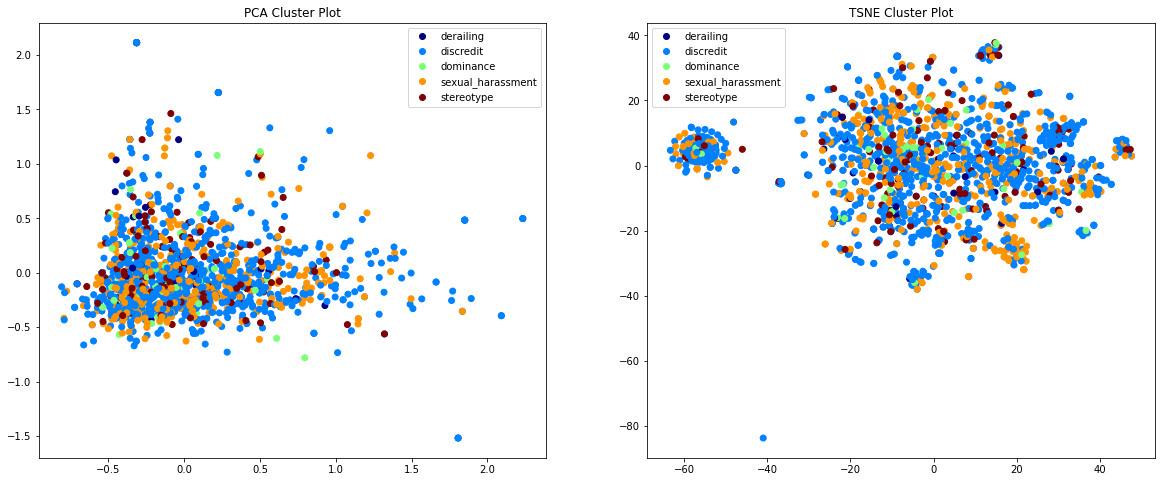

In [26]:
# no informative results
plot_tsne_pca2(docVectors, catNumbers, np.unique(categories))

Homogeneity: 0.005570371833534768


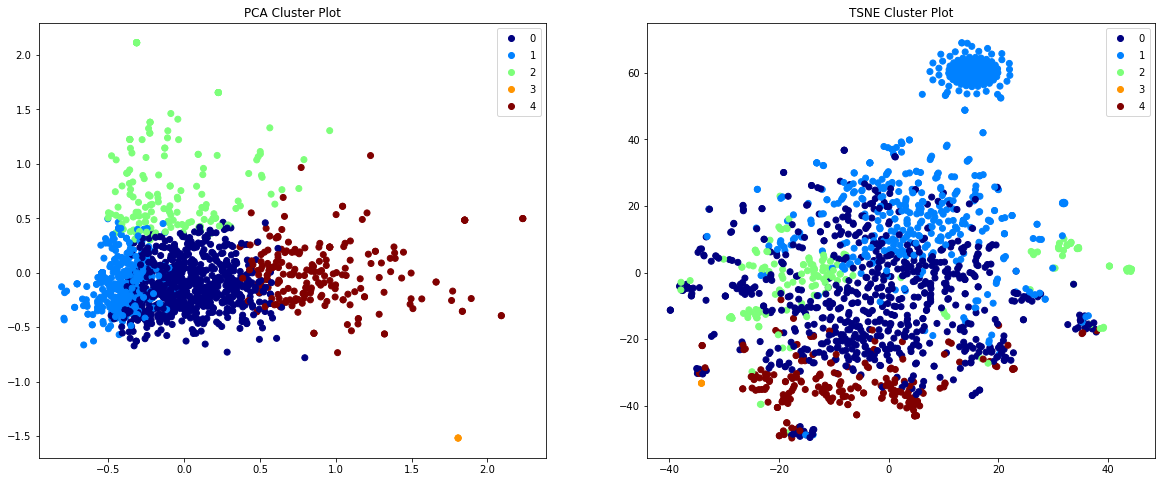

In [27]:
km = KMeans(n_clusters=5, random_state=20).fit(docVectors)
print("Homogeneity:", homogeneity_score(km.labels_.tolist(), catNumbers))
plot_tsne_pca2(docVectors, km.labels_.tolist())

## 3.3. Extracting most representative words using Word2Vec embeddings

In [28]:
# for each cluster, get ordered features by relevance
for i in range(5):
    clwords = [x[0] for x in word2vec.most_similar([km.cluster_centers_[i]], topn=5)]
    print("cluster {} top words: {}".format(i, ", ".join(clwords)))

cluster 0 top words: RUSH_Yeah, SERENA_WILLIAMS_Well, Cassell_chirped, ROBERT_BLAGOJEVICH, Hey_how'd
cluster 1 top words: %_#F########_7v.jsn, sanctuary_DellaBianca, %_#F########_9v.jsn, just, %_#F########_3v.jsn
cluster 2 top words: woman, girl, man, teenage_girl, mother
cluster 3 top words: tf, maj, maj_dec, dec, wbf
cluster 4 top words: b_*_tches, lol, cuz, juss, samantharonson_@


In [29]:
# Get the actual keywords for each category
uniquecategories = np.unique(categories)
for i in range(len(uniquecategories)):
    indices = np.where(np.array(categories) == uniquecategories[i])
    centroid = np.array(np.mean(docVectors[indices],axis=0)).flatten()
    #print(np.array(centroid).flatten())
    clwords = [x[0] for x in word2vec.most_similar([centroid], topn=5)]
    print("cluster {} top words: {}".format(uniquecategories[i], ", ".join(clwords)))

cluster derailing top words: Sorry_ma'am, RUSH_Yeah, Er_um, sanctuary_DellaBianca, TRUMP_Well
cluster discredit top words: samantharonson_@, Ding_dang, ROBERT_BLAGOJEVICH, Cassell_chirped, jennajameson_@
cluster dominance top words: pioneer_LaLanne, Cassell_chirped, Echoed_Stoops_That, sanctuary_DellaBianca, ROBERT_BLAGOJEVICH
cluster sexual_harassment top words: Cassell_chirped, Ding_dang, samantharonson_@, ROBERT_BLAGOJEVICH, Hey_how'd
cluster stereotype top words: Cassell_chirped, ROBERT_BLAGOJEVICH, BLATHER_1, SERENA_WILLIAMS_Well, RUSH_Yeah


Not really comprehensible, seems like the centroids of all documents of different categories are very close together.

# 4. Grouping tweets by category to explore their similarities

## 4.1. Grouping tweets and aggregating word2vec embeddings for each category

In [30]:
# Group tweets by categories.
uniquecategories = np.unique(categories)
tweetsNP = np.array(tweets)
tweetsByCategory = []
for i in range(len(uniquecategories)):
    indices = np.where(np.array(categories) == uniquecategories[i])
    tweetsByCategory.append(" ".join(list(tweetsNP[indices])))

In [31]:
# Clean up tweets and vectorize them into TFIDF
tfidf_vec_3 = TfidfVectorizer(max_df=1.0,
                        max_features=10000,
                        min_df=1, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

tfidf_mat3 = tfidf_vec_3.fit_transform(tweetsByCategory)
tfidf_mat3.shape

(5, 3926)

In [32]:
# prepare a single vector for each category based on top 30 keywords, weighted by tfidf
documentVectors = np.zeros((300,5))
npFeatures = np.array(tfidf_vec_3.get_feature_names())
for i in range(5):
    row = np.array(tfidf_mat3.getrow(i).todense()).flatten()
    indices = row.argsort()[::-1][:30]
    print(uniquecategories[i], ":\n" + ', '.join(npFeatures[indices]), "\n")
    for ix in indices:
        if npFeatures[ix] in word2vec:
            documentVectors[:,i] += word2vec[npFeatures[ix]] * row[ix]

derailing :
woman, dumbass, forward, men, come, sharia, slutty, birth, every, lol, sign, asked, told, assault, free, sexism, dress, sexual, understand, cuz, pregnant, theyre, control, oh, fat, wants, 😍😍😍😍, shove, antifeminist, abusive 

discredit :
bitches, woman, one, time, men, think, hoes, still, never, love, say, ya, tell, girls, nigga, girlfriend, gon, people, would, something, let, life, see, even, man, make, ur, fuckin, stop, said 

dominance :
men, rights, girls, cock, shoo, one, thanks, account, show, would, need, womens, much, us, man, support, make, keep, attention, wow, time, boss, hours, 3, male, great, baby, saying, deeper, thing 

sexual_harassment :
cock, woman, love, gon, beat, girls, much, time, make, penis, hard, bitches, still, let, sucking, please, said, people, think, one, mouth, pull, yet, take, right, come, fucked, ever, need, give 

stereotype :
woman, bitches, man, love, one, going, ya, take, girls, men, every, back, nothing, anything, kitchen, always, stop, f

## 4.2. Visualizing the cosine similarity / distance

In [33]:
#normalize the vectors
documentVectors = documentVectors / np.linalg.norm(documentVectors, axis=0)

# compute matrix with pairwise cosine similarities
similarities = documentVectors.T.dot(documentVectors)

#show the 5x5 matrix
pd.DataFrame( similarities, columns=uniquecategories, index=uniquecategories )

,derailing,discredit,dominance,sexual_harassment,stereotype
derailing,1.000000,0.834758,0.754513,0.798042,0.865981
discredit,0.834758,1.000000,0.800238,0.887603,0.950691
dominance,0.754513,0.800238,1.000000,0.827113,0.815347
sexual_harassment,0.798042,0.887603,0.827113,1.000000,0.866864
stereotype,0.865981,0.950691,0.815347,0.866864,1.000000


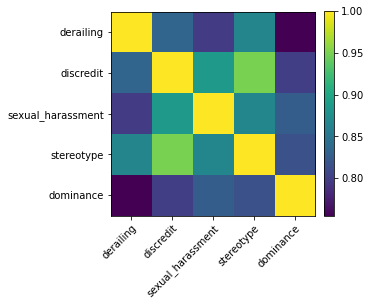

In [34]:
# cluster the categories using afinity propagation
ap = AffinityPropagation(affinity='precomputed', damping=0.51, random_state=None).fit(similarities)
ixs = np.argsort(ap.labels_)
simsorted = similarities[ixs,:][:,ixs]
uniquecatssorted = uniquecategories[ixs]

fig, ax = plt.subplots()
heatmap = plt.imshow(simsorted)
fig.set_size_inches(4, 4)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()

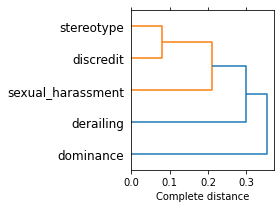

In [35]:
# hierarchical clustering using complete linkage

# use complete linkage and cosine distances to plot the dendrogram
dists1 = 1-simsorted
linkg = hierarchy.linkage(dists1, 'complete') 
fig, ax = plt.subplots(figsize=(4, 3))
ax = dendrogram(linkg, orientation="right", labels=uniquecatssorted);
plt.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
plt.xlabel("Complete distance")
plt.tight_layout()
plt.show()

Derailing & discredit are most dissimilar categories. In general derailing is quite different than all the other topics. This is expected as documents labeled as derailing have the lowest frequency of directly offensive unigrams. Sexual harrasment & discredit are most similar in terms of language, followed by dominance & stereotype. Regardless, all categories are still very "similar" globally in the embedding space. 